#### Loading libraries

In [1]:
# import Python packages and libraries
# provides functionality to train neural network
import tensorflow as tf
import pandas as pd
# provides mathematical functions to operate on arrays and matrices
import numpy as np
import random
# library to interact with operating system
import os
import glob
from os import listdir
from os.path import isfile, join
# library for generating plots
import matplotlib.pyplot as plt
# library to use data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
# for checking results
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
import aux_functions as aux_fun
%load_ext autoreload
%autoreload 2

In [2]:
import random as python_random

os.environ['TF_DETERMINISTIC_OPS'] = '1'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

### Exploratory analysis

In [2]:
# Image size
img_width, img_height =  224, 224
batch_size_n = 32

In [3]:
# list containing x axis labels
class_names = ['trash', 'glass','metal','paper','plastic','cardboard']
n_classes = len(class_names)

In [4]:
# The path to the dataset
base_dir = './dataset/waste-img'

# Directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Print number of images per directory and class
aux_fun.print_count_from_folders(train_dir,test_dir,class_names)

====== Number of images per directory and class ======
FOLDER: ./dataset/waste-img/train
trash - 357
glass - 351
metal - 348
paper - 494
plastic - 370
cardboard - 342
FOLDER: ./dataset/waste-img/test
trash - 20
glass - 150
metal - 62
paper - 100
plastic - 112
cardboard - 61


#### Load datasets

In [6]:
train_array = aux_fun.create_data_from_folder(train_dir,img_width,img_height,class_names)
test_array = aux_fun.create_data_from_folder(test_dir,img_width,img_height,class_names)

In [7]:
print(len(train_array),len(test_array))

2262 505


Separate images and labels into two different arrays

In [8]:
np.random.shuffle(train_array)
x_train, x_train_lbls = aux_fun.separate_imgs_labels(train_array)
x_train = x_train/255.0
print(x_train.shape, x_train_lbls.shape)

(2262, 224, 224, 3) (2262,)


Create validation dataset

In [9]:
train_imgs, val_imgs, train_labels, val_labels = train_test_split(x_train,x_train_lbls, test_size=0.2, random_state=42)

In [10]:
np.random.shuffle(test_array)
test_imgs, test_labels = aux_fun.separate_imgs_labels(test_array)
test_imgs = test_imgs/255.0 # normalize
print(test_imgs.shape, test_labels.shape)

(505, 224, 224, 3) (505,)


Use OneHotEncoder for the labels

In [11]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
train_labels_cat = onehotencoder.fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels_cat = onehotencoder.fit_transform(test_labels.reshape(-1,1)).toarray()
val_labels_cat = onehotencoder.fit_transform(val_labels.reshape(-1,1)).toarray()
print(train_labels_cat.shape, test_labels_cat.shape,val_labels_cat.shape)

(1809, 6) (505, 6) (453, 6)


Applying data augmentation on the training dataset

In [12]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   vertical_flip=True,
                                   horizontal_flip=True)
train_datagen.fit(train_imgs,seed=123)

In [13]:
train_imgs.shape
test_imgs.shape

(505, 224, 224, 3)

### Data augmentation

Applying data augmentation to create a new subset of samples for class "Trash"

In [24]:
# Uncomment to generate new samples for a class, "trash" in this case
#class_path = base_dir + '/train/trash/'
#img_filenames = [f for f in listdir(class_path) if isfile(join(class_path, f))]
#samples = 40
#aux_fun.iterate_images_for_transformation(class_path,img_filenames,samples)

# Uncomment to check the list of images created
#aux_fun.list_transformed_images(class_path) # add delete=True to remove all created pics

### Transfer learning

In [25]:
from tensorflow.keras.applications import ResNet50V2

img_width_res, img_height_res = 224,224

base_model = ResNet50V2(include_top=False,
                        weights='imagenet',
                        input_shape=(img_width_res, img_height_res, 3))

Fine tuning

In [26]:
base_model.trainable=True

In [27]:
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  190


In [28]:
fine_tune_at = 180
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [29]:
inputs = tf.keras.Input(shape=(img_width_res,img_height_res,3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(24, kernel_regularizer=tf.keras.regularizers.l2(0.00018), activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
model_tl = tf.keras.Model(inputs,outputs)

In [30]:
model_tl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                49176     
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 23,614,126
Trainable params: 3,465,390
Non-trainable params: 20,148,736
_________________________________________

In [31]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
model_tl.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=[tf.metrics.categorical_accuracy])

Adding callbacks

In [32]:
callback_v5= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [33]:
callback_chp = tf.keras.callbacks.ModelCheckpoint(filepath= gdrive_dir+"/checkpoint/" , 
    monitor='val_loss', save_best_only= True, save_weights_only= True)

In [34]:
history = model_tl.fit(train_datagen.flow(train_imgs,train_labels_cat, seed=32, batch_size=32), epochs=50, validation_data = (val_imgs,val_labels_cat), callbacks=[callback_v5,callback_chp])

Epoch 1/50
57/57 [==============================] - 57s 391ms/step - loss: 1.8686 - categorical_accuracy: 0.2626 - val_loss: 1.4932 - val_categorical_accuracy: 0.4172
Epoch 2/50
57/57 [==============================] - 20s 355ms/step - loss: 1.4875 - categorical_accuracy: 0.4085 - val_loss: 1.2883 - val_categorical_accuracy: 0.5121
Epoch 3/50
57/57 [==============================] - 20s 358ms/step - loss: 1.3172 - categorical_accuracy: 0.4704 - val_loss: 1.1575 - val_categorical_accuracy: 0.5320
Epoch 4/50
57/57 [==============================] - 21s 363ms/step - loss: 1.2381 - categorical_accuracy: 0.5080 - val_loss: 1.0603 - val_categorical_accuracy: 0.5894
Epoch 5/50
57/57 [==============================] - 21s 363ms/step - loss: 1.1318 - categorical_accuracy: 0.5572 - val_loss: 0.9790 - val_categorical_accuracy: 0.6490
Epoch 6/50
57/57 [==============================] - 21s 361ms/step - loss: 1.0803 - categorical_accuracy: 0.5760 - val_loss: 0.9240 - val_categorical_accuracy: 0.644

### Plot training results

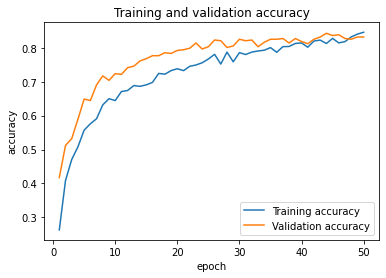

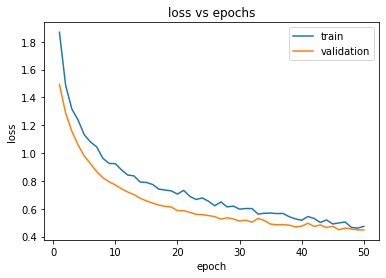

[0.26257601380348206, 0.40851297974586487, 0.47042563557624817, 0.5080154538154602, 0.5572139024734497, 0.5760088562965393, 0.5909342169761658, 0.6318408250808716, 0.6500829458236694, 0.6445550322532654, 0.6710889935493469, 0.6744057536125183, 0.6887783408164978, 0.6865671873092651, 0.6909894943237305, 0.6981757879257202, 0.7247098088264465, 0.7224985957145691, 0.7330016493797302, 0.7385295629501343, 0.7330016493797302, 0.745715856552124, 0.7495853900909424, 0.7562189102172852, 0.7672747373580933, 0.7810945510864258, 0.7523493766784668, 0.7877280116081238, 0.7589828372001648, 0.7860696315765381, 0.780541718006134, 0.7877280116081238, 0.7910447716712952, 0.7932559251785278, 0.8009950518608093, 0.7871752381324768, 0.803758978843689, 0.8043117523193359, 0.8131564259529114, 0.8148148059844971, 0.8021005988121033, 0.8203427195549011, 0.8231067061424255, 0.8131564259529114, 0.8280817866325378, 0.8148148059844971, 0.8186843395233154, 0.832504153251648, 0.8407959938049316, 0.8463239073753357]


In [35]:
def plot_history_results():
  acc      = history.history['categorical_accuracy']
  val_acc  = history.history['val_categorical_accuracy']
  loss     = history.history['loss']
  val_loss = history.history['val_loss']
  epochs   = range(1,len(acc)+1) # Get number of epochs

  plt.plot(epochs, acc,  label='Training accuracy')
  plt.plot(epochs, val_acc,  label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  ###-----plot loss---------------
  plt.plot(epochs,loss)
  plt.plot(epochs,val_loss)
  plt.title('loss vs epochs')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

  print(acc)
  print(val_acc)

  print(history.history['loss'])
  print(history.history['val_loss'])

plot_history_results()

In [36]:
test_loss, test_accuracy = model_tl.evaluate(test_imgs, test_labels_cat, batch_size=batch_size_n, verbose=2)
print('Accuracy on test dataset:', test_accuracy)

16/16 - 2s - loss: 0.4766 - categorical_accuracy: 0.8436
Accuracy on test dataset: 0.8435643315315247


#### Classification report

In [40]:
#  to get a text report showing the main classification metrics for each class
target_names = ["Class {} ({}) :".format(i,class_names[i]) for i in range(6)]

Train results

In [44]:
#get the predictions for the test data
y_train_pred = np.argmax(model_tl.predict(train_imgs), axis=-1)
y_train_true = train_labels

In [45]:
correct=np.nonzero(y_train_pred==y_train_true)[0]
incorrect=np.nonzero(y_train_pred!=y_train_true)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 1673
Incorrect predicted classes: 136


In [46]:
print(classification_report(y_train_true, y_train_pred, target_names=target_names))

                       precision    recall  f1-score   support

    Class 0 (trash) :       0.91      0.97      0.94       276
    Class 1 (glass) :       0.89      0.90      0.89       269
    Class 2 (metal) :       0.89      0.92      0.91       291
    Class 3 (paper) :       0.94      0.96      0.95       390
  Class 4 (plastic) :       0.93      0.85      0.89       303
Class 5 (cardboard) :       0.99      0.94      0.96       280

             accuracy                           0.92      1809
            macro avg       0.92      0.92      0.92      1809
         weighted avg       0.93      0.92      0.92      1809



Test results

In [37]:
#get the predictions for the test data
y_test_pred  = np.argmax(model_tl.predict(test_imgs), axis=-1)
# Get true labels 
y_test_true = test_labels

In [38]:
correct=np.nonzero(y_test_pred==y_test_true)[0]
incorrect=np.nonzero(y_test_pred!=y_test_true)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 426
Incorrect predicted classes: 79


In [41]:
print(classification_report(y_test_true, y_test_pred, target_names=target_names))

                       precision    recall  f1-score   support

    Class 0 (trash) :       0.80      0.80      0.80        20
    Class 1 (glass) :       0.88      0.74      0.80       150
    Class 2 (metal) :       0.72      0.87      0.79        62
    Class 3 (paper) :       0.88      0.91      0.90       100
  Class 4 (plastic) :       0.82      0.89      0.85       112
Class 5 (cardboard) :       0.92      0.89      0.90        61

             accuracy                           0.84       505
            macro avg       0.84      0.85      0.84       505
         weighted avg       0.85      0.84      0.84       505



#### Confusion matrix

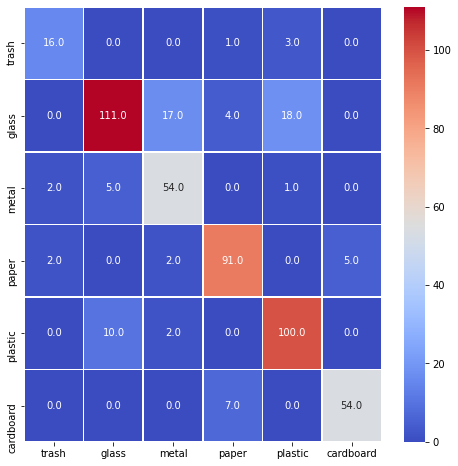

In [42]:
conf = confusion_matrix(y_test_true, y_test_pred)
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(conf, annot=True, fmt='.1f', xticklabels=class_names, yticklabels=class_names, cmap='coolwarm', linewidths=.5, ax=ax)